In [1]:
%load_ext autoreload
%autoreload 2

import warnings
from functools import partial
from typing import Mapping

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import wandb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from biobank_olink.constants import PROJECT_DATA

warnings.filterwarnings('ignore', category=UserWarning)
nb_data = PROJECT_DATA / "olink"
olink_xlsx = nb_data / "Olink population_ASI_only.xlsx"

sns.set_theme()
pl.__version__

'1.7.1'

In [2]:
index_cols = ["sex", "age", "BMI", "Smokinstatus", "HTNgroup", "ASI"]
cols = ["protein_id", "result"] + index_cols

coding = pl.read_csv(nb_data / "coding143.tsv", separator="\t").with_columns(
    pl.col("meaning").str.split(";").list.get(0).alias("meaning"),
)
df = (
    pl.scan_parquet(olink_xlsx.with_suffix(".parquet"))
    .select(cols)
    .filter(pl.col("ASI").is_not_null(), pl.col("HTNgroup") != 2)
    .with_columns(
        pl.col("protein_id").replace_strict(
            coding["coding"], coding["meaning"], return_dtype=pl.String
        )
    )
).collect()

df = df.pivot(on="protein_id", index=index_cols, values="result")
df_all = (
    df.with_columns(
        df["Smokinstatus"].to_dummies(drop_first=True)
    )
    .drop("Smokinstatus")
    .filter(pl.col("ASI") < 25)
)

df_htn = df_all.filter(pl.col("HTNgroup") == 1).drop("HTNgroup")
df_ntn = df_all.filter(pl.col("HTNgroup") == 0).drop("HTNgroup")
"all: {}, htn: {}, ntn: {}".format(df_all.shape, df_htn.shape, df_ntn.shape)

'all: (9532, 2931), htn: (3912, 2930), ntn: (5620, 2930)'

In [3]:
def shap_to_importance(values, feat_names) -> pd.Series:
    return (
        pd.Series(np.abs(values.values).sum(axis=0), index=feat_names)
        .sort_values(ascending=False)
    )


def print_true_vs_pred(y_true, y_pred, title="Train"):
    ax = sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
    max_lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_lim = min(ax.get_xlim()[0], ax.get_ylim()[0])
    ax.set(xlabel="y_true", ylabel="y_pred", title=title,
           xlim=(min_lim, max_lim), ylim=(min_lim, max_lim))


def setup_xgb(config: Mapping, seed=42, device="gpu") -> xgb.XGBRegressor:
    xgb_params = dict(config)

    early_stop = xgb.callback.EarlyStopping(
        rounds=10, save_best=True
    )

    return xgb.XGBRegressor(
        tree_method="hist",
        device=device,
        random_state=seed,
        callbacks=[early_stop],
        **xgb_params,
    )


def eval_xgb(x, y, config, seed=42, device="gpu") -> xgb.XGBRegressor:
    x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=seed)

    clf = setup_xgb(config, seed, device)
    clf.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], verbose=10)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    y_train_pred = clf.predict(x_train)
    corr_train = np.corrcoef(y_train, y_train_pred)[1, 0]
    print_true_vs_pred(y_train, y_train_pred,
                       title=f"Train (r2={clf.score(x_train, y_train):.4f}, corr={corr_train:.4f})")

    plt.subplot(1, 2, 2)
    y_eval_pred = clf.predict(x_eval)
    corr_eval = np.corrcoef(y_eval, y_eval_pred)[1, 0]
    print_true_vs_pred(y_eval, y_eval_pred,
                       title=f"Eval (r2={clf.score(x_eval, y_eval):.4f}, corr={corr_eval:.4f})")
    return clf


def get_elbow_point(series: pd.Series) -> int:
    from kneed import KneeLocator

    x = np.arange(0, len(series))
    y = series.values
    kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow

    ax = series.plot.line()
    ax.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    return elbow_point


## XGBoost

### ALL

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:2.90685
[10]	validation_0-rmse:2.79267
[20]	validation_0-rmse:2.74705
[30]	validation_0-rmse:2.72061
[40]	validation_0-rmse:2.71224
[50]	validation_0-rmse:2.71084
[60]	validation_0-rmse:2.70702
[70]	validation_0-rmse:2.70229
[80]	validation_0-rmse:2.70056
[87]	validation_0-rmse:2.70093


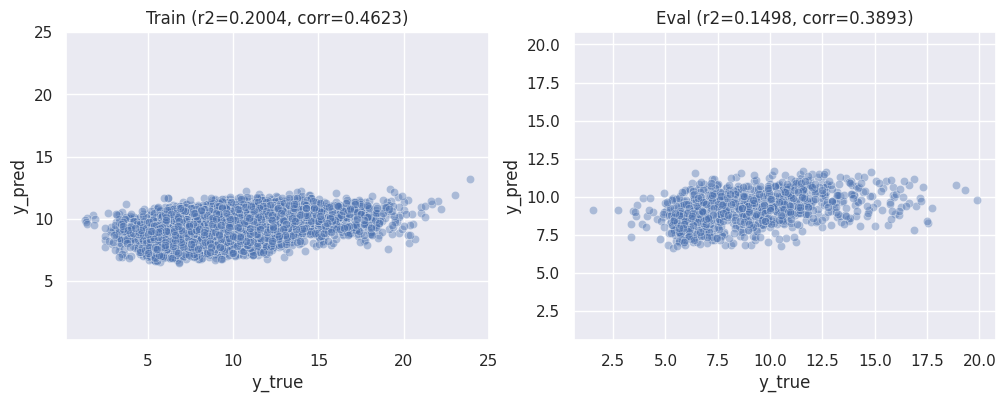

In [4]:
x_all, y_all = df_all.drop("ASI"), df_all["ASI"]
all_sweep = wandb.Api().sweep("olink_asi_all/9wica2px")
best_run = all_sweep.best_run(order="r2")
model_all = eval_xgb(x_all, y_all, best_run.config)

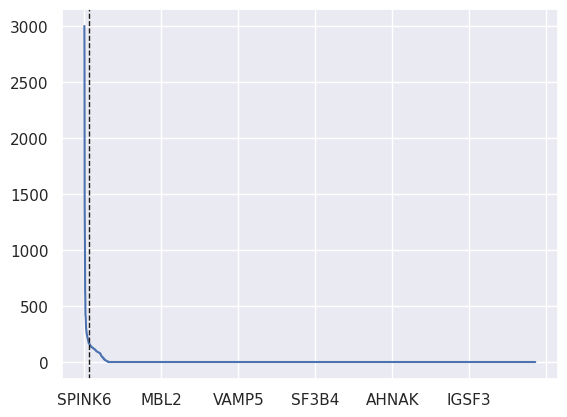

In [5]:
explainer = shap.TreeExplainer(model_all)
shap_values_all = explainer(x_all)
imps = shap_to_importance(shap_values_all, x_all.columns)
all_elbow = get_elbow_point(imps)
all_important_feats = imps[:all_elbow]

In [6]:
all_important_feats.index.values, f"Number of important feats: {len(all_important_feats)}"

(array(['SPINK6', 'age', 'sex', 'CDHR2', 'CXCL17', 'GDF15', 'HTNgroup',
        'BCAN', 'DSG2', 'SEZ6L2', 'MLN', 'PLAT', 'GUSB', 'TNR', 'TCL1A',
        'CPM', 'PAEP', 'SSC4D', 'IGSF9', 'HGF', 'SHISA5', 'TNFRSF13C',
        'ACY1', 'SELE', 'PON3', 'PRAP1', 'GSTA3', 'PRCP'], dtype=object),
 'Number of important feats: 28')

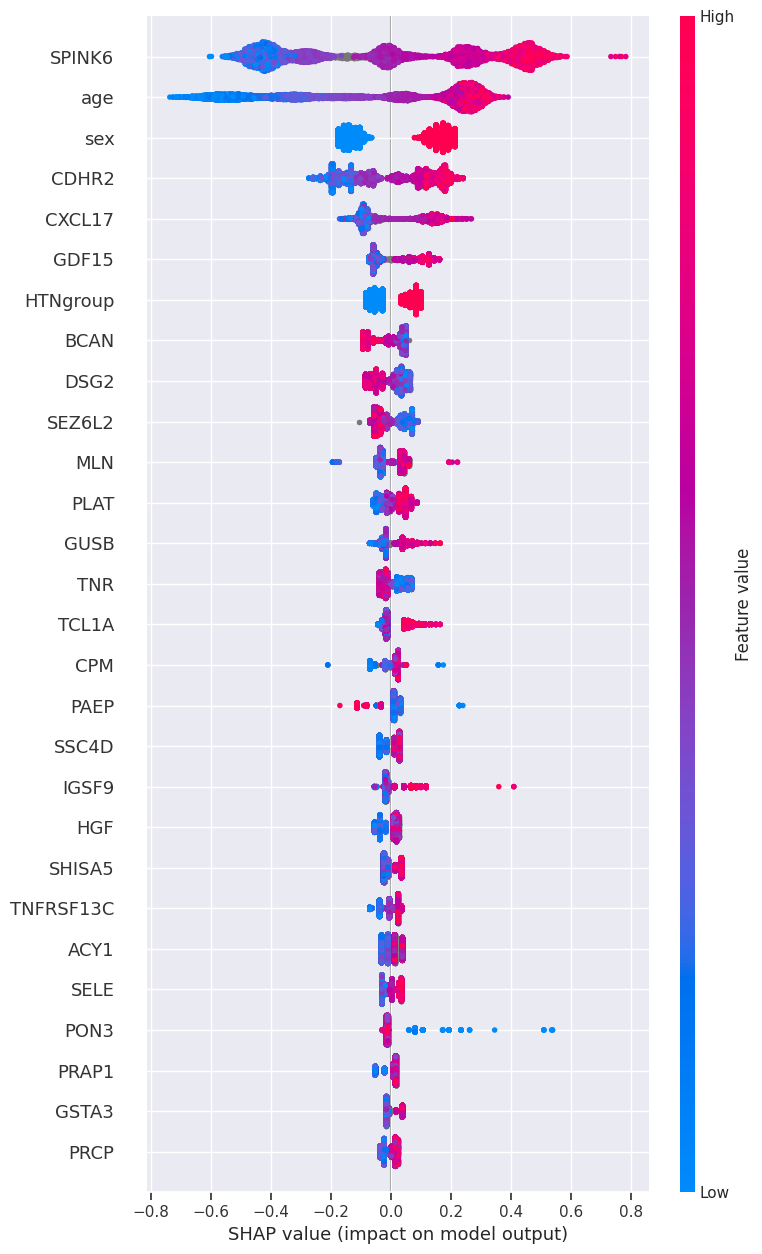

In [7]:
shap.summary_plot(shap_values_all, x_all.to_pandas(), max_display=max(len(all_important_feats), 20))

### NTN

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:2.64900
[10]	validation_0-rmse:2.59555
[20]	validation_0-rmse:2.56272
[30]	validation_0-rmse:2.53645
[40]	validation_0-rmse:2.52504
[50]	validation_0-rmse:2.51329
[60]	validation_0-rmse:2.50623
[70]	validation_0-rmse:2.49529
[80]	validation_0-rmse:2.49111
[90]	validation_0-rmse:2.48974
[99]	validation_0-rmse:2.49048


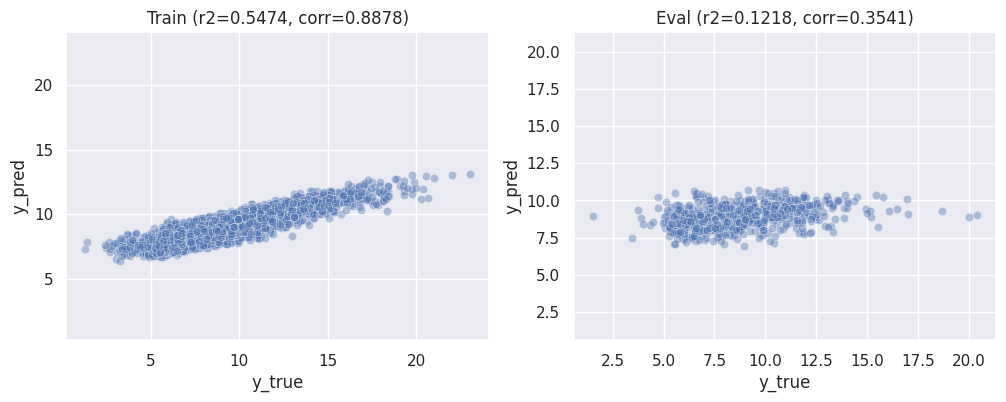

In [8]:
x_ntn, y_ntn = df_ntn.drop("ASI"), df_ntn["ASI"]

htn_sweep = wandb.Api().sweep("olink_asi_ntn/sh6dtmsj")
best_run = htn_sweep.best_run(order="r2")
model_ntn = eval_xgb(x_ntn, y_ntn, best_run.config)

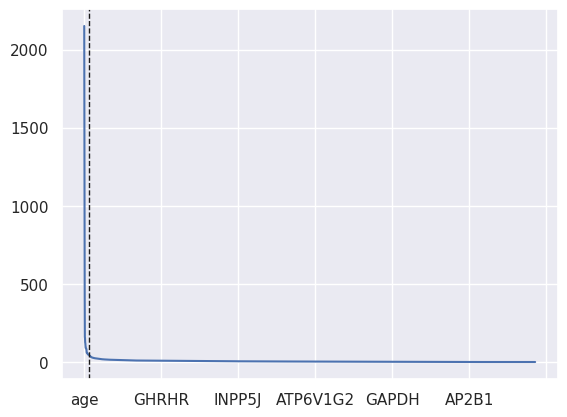

In [9]:
explainer = shap.TreeExplainer(model_ntn)
shap_values_ntn = explainer(x_ntn)
imps = shap_to_importance(shap_values_ntn, x_ntn.columns)
ntn_elbow = get_elbow_point(imps)
ntn_important_feats = imps[:ntn_elbow]

In [10]:
ntn_important_feats.index.values, f"Number of important feats: {len(ntn_important_feats)}"

(array(['age', 'SPINK6', 'CXCL17', 'sex', 'GDF15', 'UMOD', 'CPM', 'IGFBP1',
        'ACP5', 'NPL', 'CA12', 'SSC5D', 'PRCP', 'CDHR2', 'PLAT', 'PAEP',
        'SEZ6L2', 'NCAN', 'TP53BP1', 'ALDH1A1', 'PSPN', 'SHBG', 'THOP1',
        'CD80', 'LILRA6', 'CNTN1', 'ADGRG2', 'SPINK2', 'SSC4D', 'CD33',
        'BCAN', 'CALCA', 'NPPB'], dtype=object),
 'Number of important feats: 33')

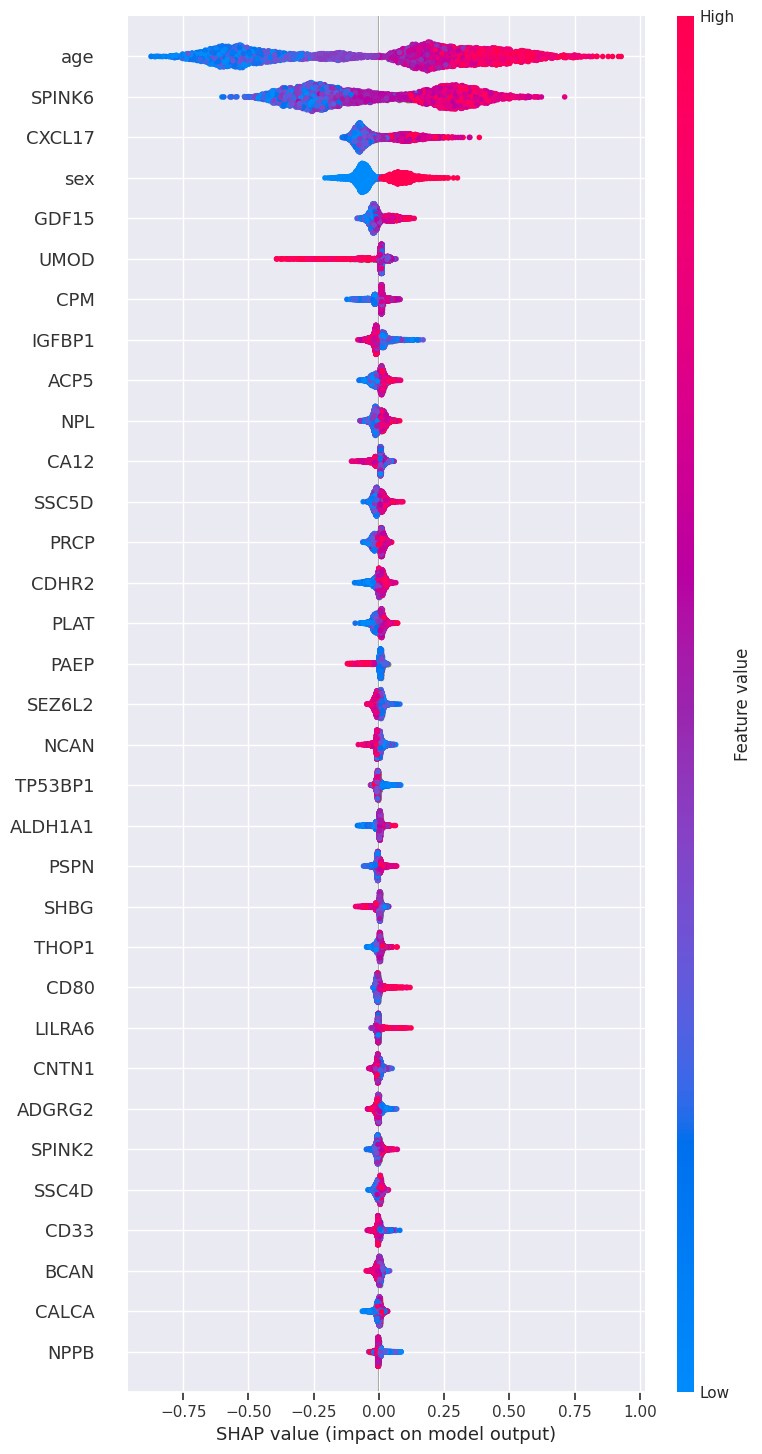

In [11]:
shap.summary_plot(shap_values_ntn, x_ntn.to_pandas(), max_display=max(len(ntn_important_feats), 20))

In [12]:
matteos_ntn_feats = set(
    pl.scan_csv(nb_data / "GLM Olink ASI ntn ZscoreAll.csv", skip_rows=1)
    .filter(pl.col("Sig.-adj FDR") <= 0.05)
    .select(pl.col("protein_name").str.split(";").list.first().alias("protein_name"))
    .collect()
    ["protein_name"]
    .to_list()
)

same_feats_ntn = (matteos_ntn_feats & set(ntn_important_feats.index))
same_feats_ntn, len(same_feats_ntn)

({'ACP5',
  'ADGRG2',
  'ALDH1A1',
  'BCAN',
  'CD80',
  'CDHR2',
  'CPM',
  'CXCL17',
  'GDF15',
  'IGFBP1',
  'NPL',
  'PLAT',
  'PRCP',
  'SHBG',
  'SPINK2',
  'SPINK6',
  'SSC4D',
  'SSC5D',
  'THOP1',
  'UMOD'},
 20)

### htn

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:3.14475
[10]	validation_0-rmse:3.07317
[20]	validation_0-rmse:3.04985
[30]	validation_0-rmse:3.04162
[40]	validation_0-rmse:3.03210
[50]	validation_0-rmse:3.02705
[55]	validation_0-rmse:3.02138


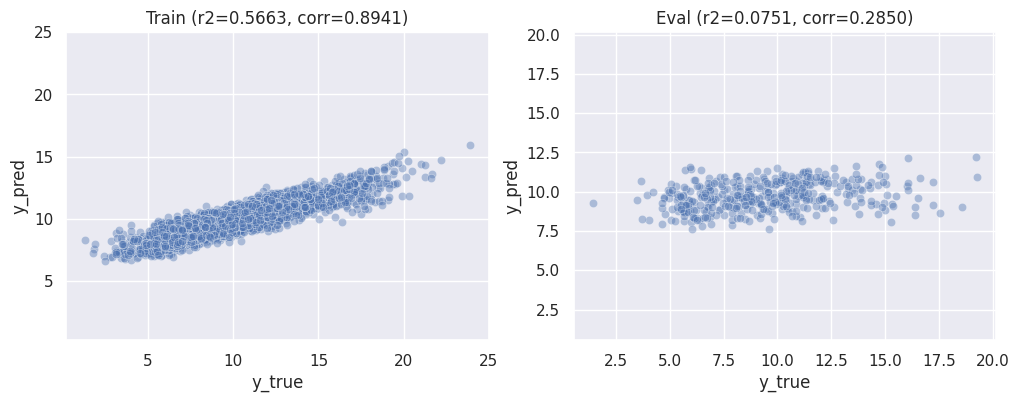

In [13]:
htn_sweep = wandb.Api().sweep("olink_asi_htn/mehz3cf5")
best_run = htn_sweep.best_run(order="r2")

x_htn, y_htn = df_htn.drop("ASI"), df_htn["ASI"]
model_htn = eval_xgb(x_htn, y_htn, best_run.config)

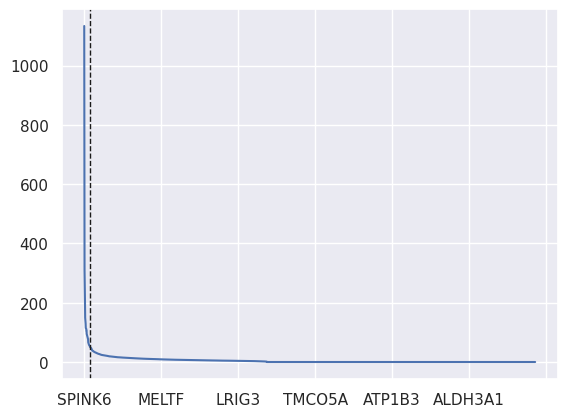

In [14]:
explainer = shap.TreeExplainer(model_htn)
shap_values_htn = explainer(x_htn)
imps = shap_to_importance(shap_values_htn, x_htn.columns)
htn_elbow = get_elbow_point(imps)
htn_important_feats = imps[:htn_elbow]

In [16]:
htn_important_feats.index.values, f"Number of important feats: {len(htn_important_feats)}"

(array(['SPINK6', 'CDHR2', 'GUSB', 'age', 'WFIKKN2', 'GDF15', 'DCXR',
        'HAVCR1', 'GGT1', 'BCAN', 'HGF', 'MLN', 'CDCP1', 'sex', 'SPINK5',
        'KITLG', 'CXCL14', 'CTSZ', 'IL1RN', 'TNFRSF13C', 'ACE2', 'PTP4A3',
        'CHI3L1', 'KEL', 'TNFRSF10B', 'ITGAM', 'BOC', 'OPTC', 'SAP18',
        'PON3', 'SLC39A5', 'TNR', 'ARSB', 'PTPRR', 'DSG2', 'PGA4', 'CPM',
        'SELE', 'VTI1A'], dtype=object),
 'Number of important feats: 39')

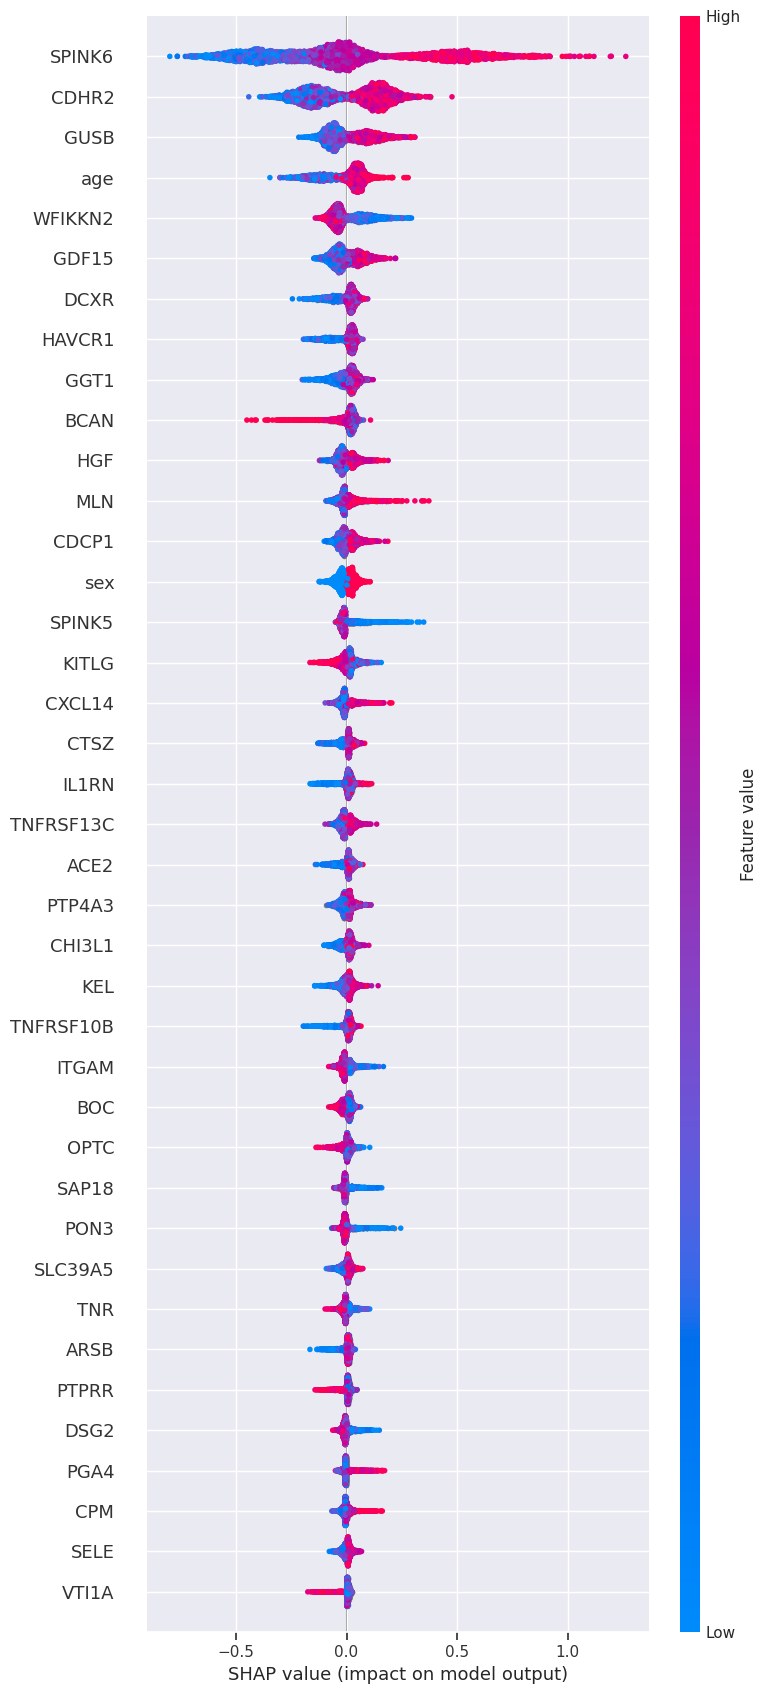

In [17]:
shap.summary_plot(shap_values_htn, x_htn.to_pandas(), max_display=max(len(htn_important_feats), 20))

In [18]:
matteos_feats_htn = set(
    pl.scan_csv(nb_data / "GLM Olink ASI htn ZscoreAll.csv", skip_rows=1)
    .filter(pl.col("Sig.-adj FDR") <= 0.05)
    .select(pl.col("ptotein_name").str.split(";").list.first().alias("protein_name"))
    .collect()
    ["protein_name"]
    .to_list()
)

same_feats_htn = (matteos_feats_htn & set(htn_important_feats.index))
same_feats_htn, len(same_feats_htn)

({'ACE2',
  'ARSB',
  'BCAN',
  'BOC',
  'CDCP1',
  'CDHR2',
  'CPM',
  'CTSZ',
  'DCXR',
  'DSG2',
  'GDF15',
  'GGT1',
  'GUSB',
  'HAVCR1',
  'HGF',
  'IL1RN',
  'KEL',
  'KITLG',
  'OPTC',
  'PON3',
  'PTP4A3',
  'SELE',
  'SLC39A5',
  'SPINK6',
  'TNFRSF13C',
  'WFIKKN2'},
 26)

## Wandb sweep

In [ ]:
def wandb_eval_xgb(config, x, y, seed=42):
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=seed)

    estimator = setup_xgb(config, seed)
    estimator.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    return estimator.score(X_eval, y_eval)


df = df_all
df_name = "all"
x, y = df.drop("ASI", axis=1), df["ASI"]

objective = partial(wandb_eval_xgb, x=x, y=y)


def main():
    wandb.init(project=f"olink_asi_{df_name}")
    score = max(objective(wandb.config), -10)
    wandb.log({"r2": score})


sweep_configurations = {
    "method": "bayes",
    "metric": {"name": "r2", "goal": "maximize"},
    "parameters": {
        'n_estimators': {'distribution': 'int_uniform', 'min': 50, 'max': 500},
        'max_depth': {'distribution': 'int_uniform', 'min': 1, 'max': 10},
        'learning_rate': {'distribution': 'log_uniform_values', 'min': 0.001, 'max': 0.1},
        'subsample': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'gamma': {'distribution': 'uniform', 'min': 0, 'max': 10},
        'min_child_weight': {'distribution': 'int_uniform', 'min': 1, 'max': 20},
        'reg_alpha': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
        'reg_lambda': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
    },
}

sweep_id = wandb.sweep(sweep_configurations, project=f"olink_asi_{df_name}")
sweep_id

In [ ]:
wandb.teardown()
wandb.agent(sweep_id, function=main)

wandb: WARNING Unable to render progress bar, see the user log for details
wandb: ERROR Problem finishing run
